# Newton's Method for Nonlinear Equations

In order to solve $$g(x) = 0,$$ apply the following steps:

solve $$\nabla g(x_k) d_k = -g(x_k)$$ and update $$x_{k+1} = x_k + d_k$$

With $g = \nabla f$, the procedure becomes:

solve $$\nabla^2 f(x_k) d_k = -\nabla f(x_k)$$ and update $$x_{k+1} = x_k + d_k$$

In [1]:
] add Plots

    Updating registry at `~/.julia/registries/General`
    Updating git-repo `https://github.com/JuliaRegistries/General.git`
    Updating registry at `~/.julia/registries/PackageNursery`
    Updating git-repo `https://github.com/j-fu/PackageNursery.jl.git`
   Resolving package versions...
  No Changes to `~/Dropbox/PostDocMTL/Teaching/MTH8408/Olds/OldNotebooks/Project.toml`
  No Changes to `~/Dropbox/PostDocMTL/Teaching/MTH8408/Olds/OldNotebooks/Manifest.toml`


In [2]:
using LinearAlgebra
using Printf
using Plots

In [3]:
function newton(g, H, x0)
    x = x0
    gx = g(x)
    gnorm = norm(gx)
    k = 0
    @printf  "%2s  %7s\n" "it" "‖∇f(x)‖"
    @printf "%2d  %7.1e\n" k gnorm
    while gnorm > 1.0e-5
        Hx = H(x)
        x -= Hx \ gx  # x = x - Hx \ gx
        gx = g(x)
        gnorm = norm(gx)
        k += 1
        @printf "%2d  %7.1e\n" k gnorm
    end
    return x
end

newton (generic function with 1 method)

In [4]:
g(x) = 6 * [x[1]^2 - x[1] - 2*x[1]*x[2] + x[2]^2 + x[2] ; -x[1]^2 + 2*x[1]*x[2] + x[1]]
H(x) = 6 * [2*x[1] - 1 - 2*x[2]  -2*x[1] + 2*x[2] + 1 ; -2*x[1] + 2*x[2] + 1  2*x[1]]

H (generic function with 1 method)

In [5]:
g([0, 0])

2-element Vector{Int64}:
 0
 0

In [6]:
H([0, 0])

2×2 Matrix{Int64}:
 -6  6
  6  0

In [7]:
newton(g, H, [.5, .5])

it  ‖∇f(x)‖
 0  4.5e+00
 1  8.4e-01
 2  7.6e-02
 3  9.1e-04
 4  1.4e-07


2-element Vector{Float64}:
 2.3230573665069826e-8
 2.3230573665069826e-8

In [8]:
newton(g, H, [1.5, 0.5])

it  ‖∇f(x)‖
 0  4.5e+00
 1  8.4e-01
 2  7.6e-02
 3  9.1e-04
 4  1.4e-07


2-element Vector{Float64}:
 1.0000000232305737
 2.323057370686582e-8

In [9]:
newton(g, H, [-2, -2])

it  ‖∇f(x)‖
 0  1.2e+01
 1  2.7e+00
 2  4.3e-01
 3  2.4e-02
 4  9.2e-05
 5  1.4e-09


2-element Vector{Float64}:
 -1.0000000002328306
 -1.0000000002328306

In [10]:
newton(g, H, [0.5, -2])

it  ‖∇f(x)‖
 0  2.5e+01
 1  5.9e+00
 2  1.2e+00
 3  1.3e-01
 4  2.3e-03
 5  6.7e-07


2-element Vector{Float64}:
  7.935378678973742e-8
 -1.0000000002328306

## Armijo Linesearch

In [11]:
f(x) = x[1]^2 * (2*x[1] - 3) - 6*x[1]*x[2] * (x[1] - x[2] - 1)

f (generic function with 1 method)

In [12]:
f([0, 0])

0

In [13]:
function armijo(xk, dk, fk, gk, f)
    slope = dot(gk, dk)  # doit être < 0
    t = 1
    while f(xk + t * dk) > fk + 1.0e-4 * t * slope
        t /= 1.5
    end
    return t
end

armijo (generic function with 1 method)

In [14]:
xk = [1.5, 0.5]
fk = f(xk)
gk = g(xk)
dk = -gk
armijo(xk, dk, fk, gk, f)

0.0877914951989026

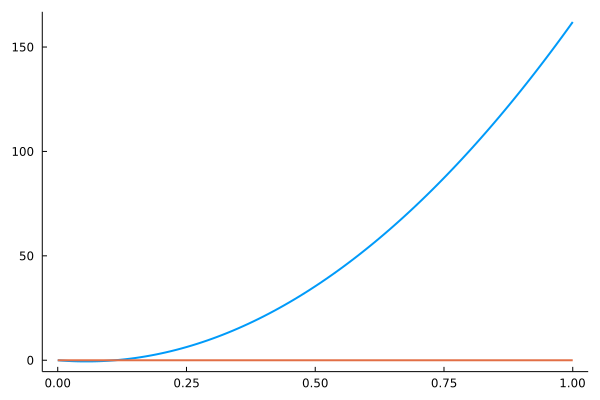

In [15]:
ts = 0:0.01:1
plot(ts, [f(xk + t * dk) for t ∈ ts], linewidth=2, legend=false, grid=false)
plot!(ts, [fk + 1.0e-4 * t * dot(gk, dk) for t ∈ ts], linewidth=2)

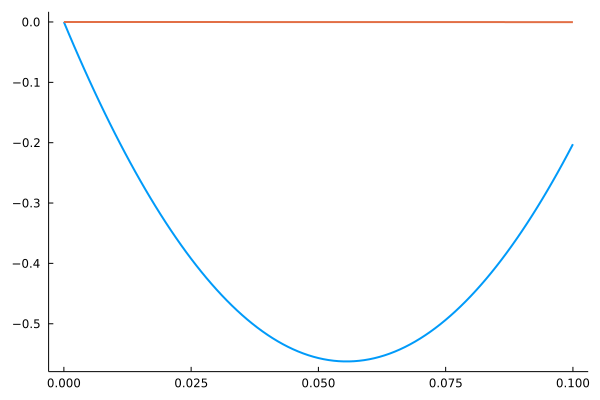

In [16]:
ts = 0:0.001:0.1
plot(ts, [f(xk + t * dk) for t ∈ ts], linewidth=2, legend=false, grid=false)
plot!(ts, [fk + 1.0e-4 * t * dot(gk, dk) for t ∈ ts], linewidth=2)

## Newton's Method (modified) for optimization

In [17]:
function newton_optim(f, g, H, x0)
    xk = x0
    fk = f(xk)
    gk = g(xk)
    gnorm = gnorm0 = norm(gk)
    k = 0
    @printf "%2s  %9s  %7s  %7s  %7s\n" "k" "fk" "‖∇fk‖" "t" "λ"
    @printf "%2d  %9.2e  %7.1e\n" k fk gnorm
    while gnorm > 1.0e-6 + 1.0e-6 * gnorm0 && k < 100
        Hk = H(xk)
        dk = -(Hk \ gk)
        slope = dot(dk, gk)
        λ = 0
        while slope ≥ -1.0e-4 * norm(dk) * gnorm
            λ = max(1.0e-3, 10 * λ)
            dk = -((Hk + λ * I) \ gk)
            slope = dot(dk, gk)
        end
        t = armijo(xk, dk, fk, gk, f)
        xk += t * dk
        fk = f(xk)
        gk = g(xk)
        gnorm = norm(gk)
        k += 1
        @printf "%2d  %9.2e  %7.1e  %7.1e  %7.1e\n" k fk gnorm t λ
    end
    return xk
end

newton_optim (generic function with 1 method)

In [18]:
newton_optim(f, g, H, [.5, .5])

 k         fk    ‖∇fk‖        t        λ
 0   1.00e+00  4.5e+00
 1   5.08e-02  8.4e-01  1.0e+00  0.0e+00
 2   4.73e-04  7.6e-02  1.0e+00  0.0e+00
 3   6.97e-08  9.1e-04  1.0e+00  0.0e+00
 4   1.62e-15  1.4e-07  1.0e+00  0.0e+00


2-element Vector{Float64}:
 2.3230573665069826e-8
 2.3230573665069826e-8

In [19]:
f([0, 0])

0

In [20]:
newton_optim(f, g, H, [1.5, .5])

 k         fk    ‖∇fk‖        t        λ
 0   0.00e+00  4.5e+00
 1  -9.49e-01  8.4e-01  1.0e+00  0.0e+00
 2  -1.00e+00  7.6e-02  1.0e+00  0.0e+00
 3  -1.00e+00  9.1e-04  1.0e+00  0.0e+00
 4  -1.00e+00  1.4e-07  1.0e+00  0.0e+00


2-element Vector{Float64}:
 1.0000000232305737
 2.323057370686582e-8

In [21]:
newton_optim(f, g, H, [-2, -2])

 k         fk    ‖∇fk‖        t        λ
 0  -4.00e+00  1.2e+01
 1  -6.21e+00  1.6e+01  1.0e+00  1.0e+02
 2  -1.01e+01  2.1e+01  1.0e+00  1.0e+02
 3  -1.67e+01  2.7e+01  1.0e+00  1.0e+02
 4  -2.79e+01  3.6e+01  1.0e+00  1.0e+02
 5  -4.73e+01  4.7e+01  1.0e+00  1.0e+02
 6  -8.32e+01  6.5e+01  1.0e+00  1.0e+02
 7  -1.59e+02  9.7e+01  1.0e+00  1.0e+02
 8  -3.65e+02  1.7e+02  1.0e+00  1.0e+02
 9  -1.26e+03  3.8e+02  1.0e+00  1.0e+02
10  -2.15e+04  2.5e+03  1.0e+00  1.0e+02
11  -3.03e+04  3.2e+03  1.0e+00  1.0e+03
12  -4.49e+04  4.1e+03  1.0e+00  1.0e+03
13  -7.13e+04  5.6e+03  1.0e+00  1.0e+03
14  -1.25e+05  8.1e+03  1.0e+00  1.0e+03
15  -2.56e+05  1.3e+04  1.0e+00  1.0e+03
16  -7.03e+05  2.6e+04  1.0e+00  1.0e+03
17  -4.31e+06  8.6e+04  1.0e+00  1.0e+03
18  -5.19e+06  9.7e+04  1.0e+00  1.0e+04
19  -6.35e+06  1.1e+05  1.0e+00  1.0e+04
20  -7.87e+06  1.3e+05  1.0e+00  1.0e+04
21  -9.95e+06  1.5e+05  1.0e+00  1.0e+04
22  -1.28e+07  1.8e+05  1.0e+00  1.0e+04
23  -1.70e+07  2.1e+05  1.0e+00  1

2-element Vector{Float64}:
 -1.4703502142766705e10
 -3.3038469418512856e10

In [22]:
newton_optim(f, g, H, [.0, -1.1])

 k         fk    ‖∇fk‖        t        λ
 0   0.00e+00  6.6e-01
 1  -4.12e-02  6.8e-01  1.0e+00  1.0e+01
 2  -1.57e-01  1.3e+00  1.0e+00  1.0e+01
 3  -7.87e-01  3.2e+00  1.0e+00  1.0e+01
 4  -1.70e+01  2.2e+01  1.0e+00  1.0e+01
 5  -2.36e+01  2.7e+01  1.0e+00  1.0e+02
 6  -3.43e+01  3.5e+01  1.0e+00  1.0e+02
 7  -5.26e+01  4.6e+01  1.0e+00  1.0e+02
 8  -8.72e+01  6.4e+01  1.0e+00  1.0e+02
 9  -1.63e+02  9.7e+01  1.0e+00  1.0e+02
10  -3.70e+02  1.7e+02  1.0e+00  1.0e+02
11  -1.28e+03  3.8e+02  1.0e+00  1.0e+02
12  -2.26e+04  2.6e+03  1.0e+00  1.0e+02
13  -3.21e+04  3.3e+03  1.0e+00  1.0e+03
14  -4.80e+04  4.3e+03  1.0e+00  1.0e+03
15  -7.72e+04  5.9e+03  1.0e+00  1.0e+03
16  -1.38e+05  8.7e+03  1.0e+00  1.0e+03
17  -2.92e+05  1.4e+04  1.0e+00  1.0e+03
18  -8.62e+05  2.9e+04  1.0e+00  1.0e+03
19  -6.95e+06  1.2e+05  1.0e+00  1.0e+03
20  -8.70e+06  1.4e+05  1.0e+00  1.0e+04
21  -1.11e+07  1.6e+05  1.0e+00  1.0e+04
22  -1.45e+07  1.9e+05  1.0e+00  1.0e+04
23  -1.94e+07  2.3e+05  1.0e+00  1

2-element Vector{Float64}:
 -1.0868806952424865e9
 -2.4421987543841276e9

In [23]:
newton_optim(f, g, H, [-1.001, -1.001])

 k         fk    ‖∇fk‖        t        λ
 0   1.00e+00  6.0e-03
 1   1.00e+00  6.9e-03  1.0e+00  1.0e+02
 2   1.00e+00  7.9e-03  1.0e+00  1.0e+02
 3   1.00e+00  9.2e-03  1.0e+00  1.0e+02
 4   1.00e+00  1.1e-02  1.0e+00  1.0e+02
 5   1.00e+00  1.3e-02  1.0e+00  1.0e+02
 6   1.00e+00  1.5e-02  1.0e+00  1.0e+02
 7   1.00e+00  1.7e-02  1.0e+00  1.0e+02
 8   1.00e+00  2.0e-02  1.0e+00  1.0e+02
 9   1.00e+00  2.4e-02  1.0e+00  1.0e+02
10   1.00e+00  2.9e-02  1.0e+00  1.0e+02
11   1.00e+00  3.4e-02  1.0e+00  1.0e+02
12   1.00e+00  4.0e-02  1.0e+00  1.0e+02
13   1.00e+00  4.7e-02  1.0e+00  1.0e+02
14   1.00e+00  5.6e-02  1.0e+00  1.0e+02
15   1.00e+00  6.6e-02  1.0e+00  1.0e+02
16   1.00e+00  7.9e-02  1.0e+00  1.0e+02
17   1.00e+00  9.3e-02  1.0e+00  1.0e+02
18   1.00e+00  1.1e-01  1.0e+00  1.0e+02
19   9.99e-01  1.3e-01  1.0e+00  1.0e+02
20   9.99e-01  1.5e-01  1.0e+00  1.0e+02
21   9.99e-01  1.8e-01  1.0e+00  1.0e+02
22   9.98e-01  2.2e-01  1.0e+00  1.0e+02
23   9.98e-01  2.6e-01  1.0e+00  1

2-element Vector{Float64}:
  1.4832079452977397e-11
 -1.0000000000000002

## Steepest Descent Method

In [24]:
function steepest(f, g, x0)
    xk = x0
    fk = f(xk)
    gk = g(xk)
    gnorm = gnorm0 = norm(gk)
    k = 0
    @printf "%2s  %9s  %7s  %7s\n" "k" "fk" "‖∇fk‖" "t"
    @printf "%2d  %9.2e  %7.1e\n" k fk gnorm
    while gnorm > 1.0e-6 + 1.0e-6 * gnorm0 && k < 20
        t = armijo(xk, -gk, fk, gk, f)
        xk -= t * gk
        fk = f(xk)
        gk = g(xk)
        gnorm = norm(gk)
        k += 1
        @printf "%2d  %9.2e  %7.1e  %7.1e\n" k fk gnorm t
    end
    return xk
end

steepest (generic function with 1 method)

In [25]:
steepest(f, g, [.5, .5])

 k         fk    ‖∇fk‖        t
 0   1.00e+00  4.5e+00
 1   3.33e-01  4.4e+00  3.0e-01
 2  -2.37e+02  2.0e+02  1.0e+00
 3  -4.34e+07  6.4e+05  1.0e+00
 4  -1.31e+18  6.2e+12  1.0e+00
 5  -1.19e+39  5.8e+26  1.0e+00
 6  -9.74e+80  5.1e+54  1.0e+00
 7  -6.58e+164  3.9e+110  1.0e+00
 8       -Inf  2.3e+222  1.0e+00
 9       -Inf      Inf  1.0e+00
10       -Inf      Inf  1.0e+00
11       -Inf      Inf  1.0e+00
12       -Inf      Inf  1.0e+00
13       -Inf      Inf  1.0e+00
14       -Inf      Inf  1.0e+00
15       -Inf      Inf  1.0e+00
16       -Inf      Inf  1.0e+00
17       -Inf      Inf  1.0e+00
18       -Inf      Inf  1.0e+00
19       -Inf      Inf  1.0e+00
20       -Inf      Inf  1.0e+00


2-element Vector{Float64}:
 -Inf
  Inf

In [26]:
steepest(f, g, [1.5, .5])

 k         fk    ‖∇fk‖        t
 0   0.00e+00  4.5e+00
 1  -3.73e-01  4.2e+00  8.8e-02
 2  -1.84e+02  1.7e+02  1.0e+00
 3  -2.75e+07  4.7e+05  1.0e+00
 4  -5.29e+17  3.4e+12  1.0e+00
 5  -1.94e+38  1.7e+26  1.0e+00
 6  -2.62e+79  4.5e+53  1.0e+00
 7  -4.74e+161  3.1e+108  1.0e+00
 8       -Inf  1.5e+218  1.0e+00
 9       -Inf      Inf  1.0e+00
10       -Inf      Inf  1.0e+00
11       -Inf      Inf  1.0e+00
12       -Inf      Inf  1.0e+00
13       -Inf      Inf  1.0e+00
14       -Inf      Inf  1.0e+00
15       -Inf      Inf  1.0e+00
16       -Inf      Inf  1.0e+00
17       -Inf      Inf  1.0e+00
18       -Inf      Inf  1.0e+00
19       -Inf      Inf  1.0e+00
20       -Inf      Inf  1.0e+00


2-element Vector{Float64}:
 -Inf
  Inf

In [27]:
steepest(f, g, [-2, -2])

 k         fk    ‖∇fk‖        t
 0  -4.00e+00  1.2e+01
 1  -1.88e+03  8.5e+02  1.0e+00
 2  -2.83e+08  1.6e+06  1.0e+00
 3  -1.31e+18  3.8e+13  1.0e+00
 4  -8.08e+40  9.6e+27  6.7e-01
 5  -4.52e+84  1.4e+57  1.0e+00
 6  -1.42e+172  3.0e+115  1.0e+00
 7       -Inf  1.4e+232  1.0e+00
 8       -Inf      Inf  1.0e+00
 9       -Inf      Inf  1.0e+00
10       -Inf      Inf  1.0e+00
11       -Inf      Inf  1.0e+00
12       -Inf      Inf  1.0e+00
13       -Inf      Inf  1.0e+00
14       -Inf      Inf  1.0e+00
15       -Inf      Inf  1.0e+00
16       -Inf      Inf  1.0e+00
17       -Inf      Inf  1.0e+00
18       -Inf      Inf  1.0e+00
19       -Inf      Inf  1.0e+00
20       -Inf      Inf  1.0e+00


2-element Vector{Float64}:
 -Inf
  Inf

In [28]:
steepest(f, g, [.5, -2])

 k         fk    ‖∇fk‖        t
 0   8.50e+00  2.5e+01
 1  -5.81e+04  7.8e+03  1.0e+00
 2  -2.42e+12  9.3e+08  1.0e+00
 3  -4.07e+27  1.3e+19  1.0e+00
 4  -1.15e+58  2.6e+39  1.0e+00
 5  -9.13e+118  1.0e+80  1.0e+00
 6  -5.78e+240  1.7e+161  1.0e+00
 7       -Inf      Inf  1.0e+00
 8       -Inf      Inf  1.0e+00
 9       -Inf      Inf  1.0e+00
10       -Inf      Inf  1.0e+00
11       -Inf      Inf  1.0e+00
12       -Inf      Inf  1.0e+00
13       -Inf      Inf  1.0e+00
14       -Inf      Inf  1.0e+00
15       -Inf      Inf  1.0e+00
16       -Inf      Inf  1.0e+00
17       -Inf      Inf  1.0e+00
18       -Inf      Inf  1.0e+00
19       -Inf      Inf  1.0e+00
20       -Inf      Inf  1.0e+00


2-element Vector{Float64}:
 -Inf
  Inf

In [29]:
steepest(f, g, [-1.1, -1])

 k         fk    ‖∇fk‖        t
 0   9.68e-01  9.3e-01
 1  -1.15e+01  3.0e+01  1.0e+00
 2  -1.55e+05  1.5e+04  1.0e+00
 3  -1.67e+13  3.4e+09  1.0e+00
 4  -1.94e+29  1.7e+20  1.0e+00
 5  -2.62e+61  4.5e+41  1.0e+00
 6  -4.75e+125  3.1e+84  1.0e+00
 7  -1.56e+254  1.5e+170  1.0e+00
 8       -Inf      Inf  1.0e+00
 9       -Inf      Inf  1.0e+00
10       -Inf      Inf  1.0e+00
11       -Inf      Inf  1.0e+00
12       -Inf      Inf  1.0e+00
13       -Inf      Inf  1.0e+00
14       -Inf      Inf  1.0e+00
15       -Inf      Inf  1.0e+00
16       -Inf      Inf  1.0e+00
17       -Inf      Inf  1.0e+00
18       -Inf      Inf  1.0e+00
19       -Inf      Inf  1.0e+00
20       -Inf      Inf  1.0e+00


2-element Vector{Float64}:
 -Inf
  Inf

In [30]:
steepest(f, g, [1.0 + 1.0e-5, 0.0 + 1.0e-5])

 k         fk    ‖∇fk‖        t
 0  -1.00e+00  6.0e-05
 1  -1.00e+00  5.9e-05  1.3e-01
 2  -1.00e+00  6.0e-05  1.3e-01
 3  -1.00e+00  6.3e-05  1.3e-01
 4  -1.00e+00  2.5e-05  8.8e-02
 5  -1.00e+00  2.6e-05  1.3e-01
 6  -1.00e+00  2.7e-05  1.3e-01
 7  -1.00e+00  1.1e-05  8.8e-02
 8  -1.00e+00  1.1e-05  1.3e-01
 9  -1.00e+00  1.2e-05  1.3e-01
10  -1.00e+00  4.6e-06  8.8e-02
11  -1.00e+00  4.8e-06  1.3e-01
12  -1.00e+00  1.9e-06  8.8e-02
13  -1.00e+00  2.0e-06  1.3e-01
14  -1.00e+00  2.1e-06  1.3e-01
15  -1.00e+00  8.3e-07  8.8e-02


2-element Vector{Float64}:
 1.0000001307716546
 2.2804237348308296e-8